# CNN classifier

https://cs230.stanford.edu/lecture/



-  **Finetuning the convnet**: Instead of random initialization, we
   initialize the network with a pretrained network.



In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, ConcatDataset
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import copy

In [2]:
AVAIL_GPUS = min(1, torch.cuda.device_count())
#BATCH_SIZE = 256 if AVAIL_GPUS else 64
BATCH_SIZE = 32
NUM_WORKERS = int(os.cpu_count() / 2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name() if torch.cuda.is_available() else None)
print(BATCH_SIZE)
print(NUM_WORKERS)

NVIDIA GeForce GTX 1650 Ti
32
6


In [3]:
class ImageLoader:
    '''
    Args:
    root is the path where are stored the folders.
    phase can be 'train' or 'test', in function if
    you want a training (Augmented) or test (original) dataset.
    batch_size
    num_workers
    '''
    def __init__(self, root_train, root_test, phase, batch_size, num_workers):
        self.phase = phase
        self.root_train = root_train
        self.root_test = root_test
        self.batch_size = batch_size
        self.num_workers = num_workers
        
    def apply(self):
        transforms_dict = {
            'augmented': transforms.Compose([transforms.Resize((224,224)),
                                    #transforms.Grayscale(num_output_channels=1),
                                    transforms.ToTensor(),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomVerticalFlip()]),
            'origin': transforms.Compose([transforms.Resize((224,224)),
                                 #transforms.Grayscale(num_output_channels=1),
                                 transforms.ToTensor()])}

        df_augmented = datasets.ImageFolder(root=self.root_train, transform=transforms_dict['augmented'])
        df_origin = datasets.ImageFolder(root=self.root_train, transform=transforms_dict['origin'])
        df_train, df_val = random_split(df_origin, (round(0.85*len(df_origin)), round(0.15*len(df_origin))))
        
        df = ConcatDataset([df_train, df_augmented])
        print('train', len(df))
        print('val', len(df_val))

        if self.phase == 'train':
    
            train_loader = DataLoader(df, batch_size=self.batch_size,
                                      shuffle=True, num_workers=self.num_workers)
            val_loader = DataLoader(df_val, batch_size=self.batch_size,
                                    shuffle=False, num_workers=self.num_workers)
            return [train_loader, val_loader]
        else:
            df_test = datasets.ImageFolder(root=self.root_test, transform=transforms_dict['origin'])
            print('test', len(df_test))
                                           
            test_loader = DataLoader(df_test, batch_size=self.batch_size,
                                     shuffle=False, num_workers=self.num_workers)
            return test_loader

In [4]:
path_train = '/Users/giaco/Desktop/DSSC/CVproject/train/'
path_test = '/Users/giaco/Desktop/DSSC/CVproject/test/'
load_train = ImageLoader(root_train=path_train, root_test=path_test , phase='train', batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
img_train = load_train.apply()

load_test = ImageLoader(root_train=path_train, root_test=path_test, phase='test', batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
img_test = load_test.apply()

train 2775
val 225
train 2775
val 225
test 2985


In [5]:
df = datasets.ImageFolder(root='/Users/giaco/Desktop/DSSC/CVproject/train/', transform=transforms.Compose([transforms.Resize((64,64), interpolation=transforms.InterpolationMode.NEAREST),
                                                                                                     transforms.Grayscale(num_output_channels=1),
                                                                                                        transforms.ToTensor()]))
df_test = datasets.ImageFolder(root='/Users/giaco/Desktop/DSSC/CVproject/test/', transform=transforms.Compose([transforms.Resize((64,64), interpolation=transforms.InterpolationMode.NEAREST),
                                                                                                            transforms.Grayscale(num_output_channels=1),
                                                                                                            transforms.ToTensor()]))
                                                                                                            
dataloader = {
    'train': img_train[0],
    'val': img_train[1],
    'test': img_test
}

dataset_size = {
    'train': 2775,
    'val': 255,
    'test': 2985
}                                                                

In [ ]:
dataiter = iter(img_train[0])
images, labels = dataiter.next()

In [ ]:
def imshow(img, label):
    classes = df.classes
    plt.imshow(img.permute(1, 2, 0))
    plt.title('label:' + str(classes[label]))
    plt.show()

In [ ]:
n = int(np.random.randint(0, BATCH_SIZE))
imshow(images[n], labels[n])
images[n].shape

In [ ]:
def initialize_weights(m):
  if isinstance(m, nn.Conv2d):
      nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
      if m.bias is not None:
          nn.init.constant_(m.bias.data, 0)
  elif isinstance(m, nn.Linear):
      nn.init.kaiming_uniform_(m.weight.data)
      nn.init.constant_(m.bias.data, 0)

In [6]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 15)
#model_ft.to(device)

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optimizer = torch.optim.Adam(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [1]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=30):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloader[phase]:
                #inputs = inputs.to(device)
                #labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            
          
            epoch_loss = running_loss / dataset_size[phase]
            epoch_acc = running_corrects.double() / dataset_size[phase]

            writer.add_scalar(f"Loss {phase}", epoch_loss, epoch)
            writer.add_scalar(f"Acc {phase}", epoch_acc, epoch)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [10]:
Model = train_model(model_ft, criterion, optimizer, exp_lr_scheduler, num_epochs=25)
writer.flush()

Epoch 0/24
----------
train Loss: 1.0224 Acc: 0.6692
val Loss: 2.1289 Acc: 0.3255

Epoch 1/24
----------
train Loss: 0.5706 Acc: 0.8223
val Loss: 1.6753 Acc: 0.5333

Epoch 2/24
----------
train Loss: 0.4108 Acc: 0.8627
val Loss: 0.6553 Acc: 0.7373

Epoch 3/24
----------
train Loss: 0.3332 Acc: 0.8897
val Loss: 0.9211 Acc: 0.6471

Epoch 4/24
----------
train Loss: 0.3381 Acc: 0.8876
val Loss: 0.3866 Acc: 0.7451

Epoch 5/24
----------
train Loss: 0.2345 Acc: 0.9279
val Loss: 0.4016 Acc: 0.7490

Epoch 6/24
----------
train Loss: 0.2137 Acc: 0.9308
val Loss: 0.2593 Acc: 0.7843

Epoch 7/24
----------
train Loss: 0.0807 Acc: 0.9744
val Loss: 0.0526 Acc: 0.8627

Epoch 8/24
----------
train Loss: 0.0485 Acc: 0.9870
val Loss: 0.0331 Acc: 0.8745

Epoch 9/24
----------
train Loss: 0.0414 Acc: 0.9877
val Loss: 0.0282 Acc: 0.8784

Epoch 10/24
----------
train Loss: 0.0384 Acc: 0.9895
val Loss: 0.0230 Acc: 0.8784

Epoch 11/24
----------
train Loss: 0.0257 Acc: 0.9950
val Loss: 0.0190 Acc: 0.8784

Ep

In [ ]:
# model = model_ft()
# model.load_state_dict(torch.load("/Users/giaco/Desktop/PyTorch/CV-project/model_dict_finetoning.pt"))
# model.eval()

In [5]:
writer.close()
import tensorboard
#%load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir=runs

Reusing TensorBoard on port 6006 (pid 17068), started 8 days, 15:56:40 ago. (Use '!kill 17068' to kill it.)

In [13]:
# @torch.no_grad()
def get_predict(model, loader):
    predict_tensor = torch.tensor([])
    for batch in loader:
        images, labels = batch
        
        predict = model(images)
        # _, preds = torch.max(predict, 1)
        
        predict_tensor = torch.cat(
            (predict_tensor, predict),
            dim=0)

    return predict_tensor

In [14]:
with torch.no_grad():
    test_predict = get_predict(Model, img_test)
    
test_predict.shape

torch.Size([2985, 15])

In [15]:
print(test_predict.requires_grad)
print(test_predict.grad)
print(test_predict.grad_fn)

False
None
None


In [16]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

predict_correct = get_num_correct(test_predict, torch.tensor(df_test.targets))

print(predict_correct)
print(predict_correct/len(df_test))

2660
0.8911222780569514


In [17]:
stacked = torch.stack(
    (torch.tensor(df_test.targets),
    #test_predict.int()),
    test_predict.argmax(dim=1)),
    dim=1
)
stacked.shape

torch.Size([2985, 2])

In [18]:
cmt = torch.zeros(15,15, dtype=torch.int32)
for p in stacked:
    i,j = p.tolist()
    cmt[i,j] = cmt[i,j] + 1

In [19]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 92   0   0   0   0   1   5  18   0   0   0   0   0   0   0]
 [  0 228   2   1   0   0   0   0   0   0  29   0   0   0   0]
 [  0   0 222   0   0   0   0   0   3   0   3   0   0   0   0]
 [  0   4   0 141   3   2   1   0   1   0   3   1   4   0   0]
 [  5   0   1   3 156   7   8   2   5   0   1   9   4   1   9]
 [  0   1   0   0   6 182   5   2   0   0   0   4   3   1   4]
 [  2   0   0   0   1   1  96   6   0   2   0   2   0   0   0]
 [ 15   0   0   0   5   0  12 150   0   1   0   6   0   0   0]
 [  0   1   5   0   0   0   0   0 259   0   8   0   0   0   1]
 [  0   0   0   0   0   0   0   3   0 112   0   0   0   0   0]
 [  0  29  11   0   0   0   0   0   4   0 266   0   0   0   0]
 [  0   1   0   0   3   1   4   4   1   1   0 196   1   0   3]
 [  0   0   1   5   2   1   0   0   1   0   0   2 178   0   2]
 [  1   0   0   0   0   0   0   1   0   0   0   0   0 139   0]
 [  0   1   2   0   3   3   0   0   1   0   0   1   2   0 243]]


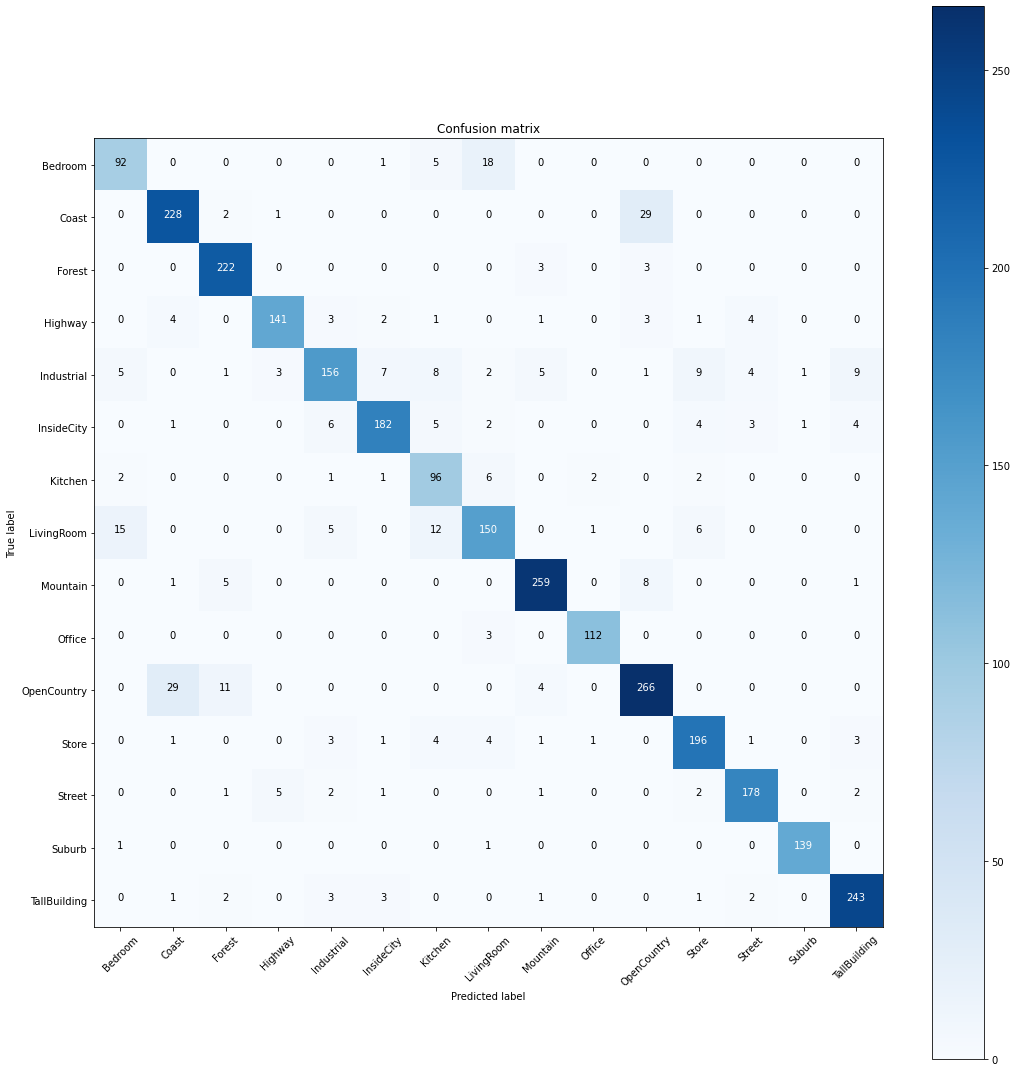

In [21]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(torch.tensor(df_test.targets), test_predict.argmax(dim=1))

names = df_test.classes
plt.figure(figsize=(15,15))
plot_confusion_matrix(cm, names)

In [26]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated



def visualize_model(model, num_images=10):
    model.load_state_dict(torch.load("/Users/giaco/Desktop/PyTorch/CV-project/model_dict_finetoning.pt"))
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader['test']):
            #inputs = inputs.to(device)
            #labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {df.classes[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

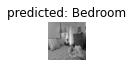

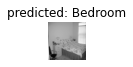

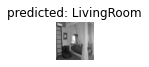

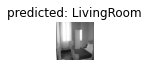

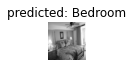

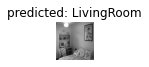

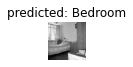

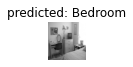

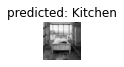

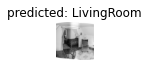

In [27]:
visualize_model(Model)

In [ ]:
# softmax classifier

class SoftMax(nn.Module):
    
    # Constructor
    def __init__(self, input_size, output_size):
        super(SoftMax, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    # Prediction
    def forward(self, x):
        z = self.linear(x)
        return z